# Péndulo invertido

Parámetros:

(M)       mass of the cart                         0.5 kg

(m)       mass of the pendulum                     0.2 kg

(b)       coefficient of friction for cart         0.1 N/m/sec

(l)       length to pendulum center of mass        0.3 m

(I)       mass moment of inertia of the pendulum   0.006 kg.m^2

(F)       force applied to the cart

(x)       cart position coordinate

(theta)   pendulum angle from vertical (down)

## Esquema

![Péndulo invertido](pendulum2.png)

## Ecuaciones linealizadas

$$
\left[{\begin{array}{c}
  \dot{x}\\ \ddot{x}\\ \dot{\phi}\\ \ddot{\phi}
\end{array}}\right] =
\left[{\begin{array}{cccc}
  0&1&0&0\\
  0&\frac{-(I+ml^2)b}{I(M+m)+Mml^2}&\frac{m^2gl^2}{I(M+m)+Mml^2}&0\\
  0&0&0&1\\
  0&\frac{-mlb}{I(M+m)+Mml^2}&\frac{mgl(M+m)}{I(M+m)+Mml^2}&0
\end{array}}\right]
\left[{\begin{array}{c}
  x\\ \dot{x}\\ \phi\\ \dot{\phi}
\end{array}}\right]+
\left[{\begin{array}{c}0\\
  \frac{I+ml^2}{I(M+m)+Mml^2}\\
  0 \\
  \frac{ml}{I(M+m)+Mml^2}
\end{array}}\right]u$$

$${\bf y} =
\left[{\begin{array}{cccc}
  1&0&0&0\\0&0&1&0
\end{array}}\right]
\left[{\begin{array}{c}
  x\\ \dot{x}\\ \phi\\ \dot{\phi}
\end{array}}\right]+
\left[{\begin{array}{c}
  0\\0
\end{array}}\right]u$$

In [1]:
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
import random

In [2]:
M = 0.5
m = 0.2
b = 0.1
I = 0.006
g = 9.8
l = 0.3
p = I*(M+m)+M*m*l**2;

a22 = -((I+m*l**2)*b/p)
a23 = ((m**2*g*l**2)/p)
b2  = ((I+m*l**2)/p)
a22,a23,b2

(-0.18181818181818182, 2.6727272727272737, 1.8181818181818181)

In [3]:
A = np.matrix([[0, 1, 0,0],
     [0, -(I+m*l**2)*b/p,  (m**2*g*l**2)/p, 0],
     [0, 0, 0,  1],
     [0, -(m*l*b)/p, m*g*l*(M+m)/p, 0]])

B =np.matrix([[0],
     [(I+m*l**2)/p],
          [0],
        [m*l/p]])

C = np.matrix([[1, 0, 0, 0],
     [0, 0, 1, 0]])

D = np.matrix([[0],
               [0]])

states = ['x', 'x_dot', 'phi', 'phi_dot']
inputs = ['u']
outputs = ['x', 'phi']

pendulo = ctrl.ss(A,B,C,D, states=states, inputs=inputs, outputs=outputs)
pendulo

<LinearIOSystem:sys[2]:['u']->['x', 'phi']>

(array([ 0.        +0.j, -0.14283164+0.j, -5.60409413+0.j,  5.56510758+0.j]),
 array([], dtype=float64))

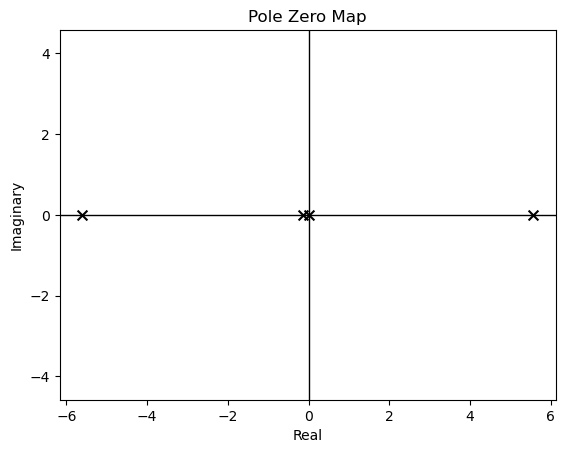

In [4]:
ctrl.pzmap(pendulo)

## Sistema lineal usando NonlinearIOSystem

In [5]:
def pendulum_lin_derivs(t, x, u, params):
    # Parámetros, tienen valores por defecto
    M=params.get('M', 0.5)#kg
    m=params.get('m', 2)#kg
    b=params.get('b', 0.1)
    I=params.get('I', 0.006)
    g=params.get('g', 9.8)#m/s^2
    l=params.get('l', 0.3)#m
        
    # variables de estado
    pos       = x[0]#m
    vel       = x[1]#m/s
    theta     = x[2]#rad
    theta_dot = x[3]#rad/s
    
    # Cálculo de la acción de control
    F = u[0] #[N] if u[0] > 0 else 0 # solo caudales positivos

    #calculo de la derivada de x, x_dot, theta, theta_dot... dh/dt
    dpos       = vel #x1_dot
    #dvel       = -((I+m*l**2)*b/p)*vel+((m**2*g*l**2)/p)*theta+((I+m*l**2)/p)*F
    dvel       = -.182*vel+2.67*theta+1.82*F#
    #dvel       = a22*vel+a23*theta+b2*F#
    dtheta     = theta_dot
    dtheta_dot = -.455*vel+31.2*theta+4.55*F
    #dtheta_dot = -(m*l*b)/p*vel+m*g*l*(M+m)/p*theta+m*l/p*F
    return np.array([dpos, dvel, theta_dot, dtheta_dot])

def pendulum_lin_outputs(t, x, u, params):
    "Las ecuaciones de las salida"
    return np.array([x[0],x[2]])#+random.normalvariate(0,0.001),x[2]+random.normalvariate(0,0.001)])

io_pendulum_lin = ctrl.NonlinearIOSystem(
    pendulum_lin_derivs, pendulum_lin_outputs, inputs=('u'), outputs=('x','phi'),
    states=('x','vel','phi','theta_dot'), name='pendulo_nolin')

## Diseño de la ley de control

Elegí lo polos lograr:

Ante un escalón de 0.2m en la posición del carro del péndulo. Bajo estas condiciones, se decide que el carro logre esta condición en un tiempo menor a 5 segundos y que tenga un tiempo de crecimiento por debajo de 0.5 segundos. También se desea que el pendulo logre la posición vertical en menos de 5 segundos, y ademas, el ángulo del pendulo no debe superar los 20 grados (0.35 radianes).

En resumen, los requerimientos de diseño para el pendulo invertido en espacio de estado ante un escalón de 0.2m, son:

1. Tiempo de establecimiento para $x$ y $\theta$ menor a 5 segundos
2. Rise time para $x$ menor a 0.5 segundos
3. Ángulo del pendulo $\theta$ no debe superar los 20 grados (0.35 radianes) de la vertical
4. El error de estado estacionario debe ser menor al 2% para $x$ y $\theta$

Traduciendo las especificaciones a requerimientos:

1. Las especificaciones temporales $t_s$ y $t_r$, limitan el ancho de banda del sistema fijando requerimientos para $w_n$, por otro lado el ancho de banda del sistema esta limitado por el polo del sistema en el semi-plano derecho, $p= 5.56$, por lo que $w_c$ deberá ser mayor a $2p$, es decir, $w_c> 11.12$, que es mas restrictivo que los requerimientos de performance.
2. Que el ángulo sea menor que 0.35rad lo podemos usar para LQR
3. Por otro lado, los errores de estado estacionario imponen restricciones a la ganancia del sistema, que verificaremos al cerrar el lazo.
4. finalmente agrego una cota para el sobrepico para acotar el movimiento de $x$ y $\theta$

In [6]:
ts = 5 #[s]
tr = .5 #[s]

sigma=4/ts
wn=1.8/tr
wc=11.5

xi=.7

print('por ts wn > ', sigma/xi, ' por tr wn > ', wn, ' por wc > 2p, wc > ', wc)

por ts wn >  1.142857142857143  por tr wn >  3.6  por wc > 2p, wc >  11.5


In [7]:
wd= wc*np.sqrt(1-xi**2)
sigma = wc*xi

print(sigma)
p1 = -sigma + 1j*wd;
p2 = -sigma - 1j*wd;
p3 = -sigma*5;
p4 = -sigma*4;
p_obj1= [p1, p2, p3, p4]

print(p_obj1)

8.049999999999999
[(-8.049999999999999+8.212642692824277j), (-8.049999999999999-8.212642692824277j), -40.24999999999999, -32.199999999999996]


In [8]:
K1 = ctrl.place(A,B,p_obj1);
print(K1)

[[-3847.81375     -683.62467857  2116.8294       292.89087143]]


### Verificación de la ley de control

In [9]:
sys_cl1 = ctrl.ss(A-B*K1,B,C,0,);

sys_cl1.pole()

array([-40.25+0.j        , -32.2 +0.j        ,  -8.05+8.21264269j,
        -8.05-8.21264269j])

Text(0, 0.5, 'Angular Posición (rad)/ Posición (m)')

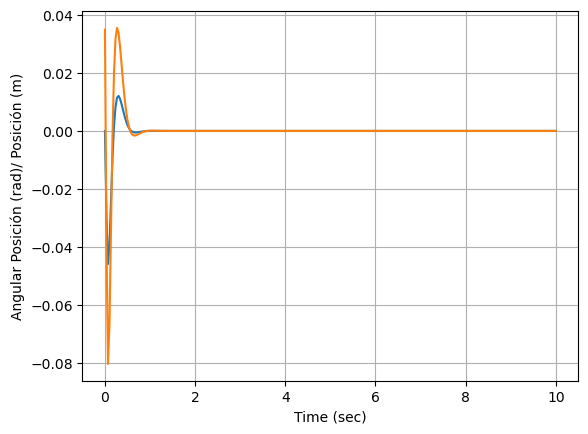

In [10]:
n = 300
tf = 10
time = np.linspace(0,tf,n)

u = np.zeros(time.size)#np.ones(time.size)*.2
x0 = [0, 0, np.radians(2), 0]#[0, 0, 0, 0]#

t1,y1,x1 =ctrl.forced_response(sys_cl1,U=u,T=time,X0=x0,return_x=True)
x=y1[0,:];
theta_a=y1[1,:];

plt.plot(t1,x)#pos
plt.plot(t1,theta_a)#angulo en rad

plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('Angular Posición (rad)/ Posición (m)')

## Estimador total

In [11]:
m_obsv = ctrl.obsv(A,C)
print('\n')
rango_obsv = np.linalg.matrix_rank(m_obsv)
print(m_obsv)
print("Rango la matriz de observabilidad:",rango_obsv)



[[ 1.          0.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.         -0.18181818  2.67272727  0.        ]
 [ 0.         -0.45454545 31.18181818  0.        ]
 [ 0.          0.03305785 -0.48595041  2.67272727]
 [ 0.          0.08264463 -1.21487603 31.18181818]]
Rango la matriz de observabilidad: 4


In [12]:
#5 veces respecto a los polos p_obj2
pe_obj1=p_obj1*np.array(5)
pe_obj1

array([ -40.25+41.06321346j,  -40.25-41.06321346j, -201.25 +0.j        ,
       -161.   +0.j        ])

In [13]:
L = ctrl.place(pendulo.A.T,pendulo.C.T,pe_obj1).T
L

array([[  198.38852995,   -44.5755901 ],
       [ 6141.34283224, -8192.81693151],
       [   36.94965219,   244.17965187],
       [ 6539.80633746,  8588.5023155 ]])

In [14]:
 np.linalg.eigvals(A-L@C)

array([ -40.25+41.06321346j,  -40.25-41.06321346j, -161.   +0.j        ,
       -201.25 +0.j        ])

In [15]:
Ae=A-L@C-B@K1 #A*x_e-B*u-L(y-C*x_e)
Be=L#np.hstack([B,L]) 
Ce=-K1# u=-K*x_e
De=np.zeros([1,2])
Ae,Be,Ce,De

(matrix([[-1.98388530e+02,  1.00000000e+00,  4.45755901e+01,
           0.00000000e+00],
         [ 8.54682168e+02,  1.24277214e+03,  4.34670893e+03,
          -5.32528857e+02],
         [-3.69496522e+01,  0.00000000e+00, -2.44179652e+02,
           1.00000000e+00],
         [ 1.09502562e+04,  3.10693036e+03, -1.81792723e+04,
          -1.33132214e+03]]),
 array([[  198.38852995,   -44.5755901 ],
        [ 6141.34283224, -8192.81693151],
        [   36.94965219,   244.17965187],
        [ 6539.80633746,  8588.5023155 ]]),
 array([[ 3847.81375   ,   683.62467857, -2116.8294    ,  -292.89087143]]),
 array([[0., 0.]]))

In [16]:
states = ['x_est', 'x_est_dot', 'phi_est', 'phi_est_dot']
inputs = ['x','phi']#la entrada y no puede ser de 2x1 tengo que separar
outputs = ['u']

#regulador con estimador total ley de control u=-k*x_est + estimador total
reg_est_tot = ctrl.ss(Ae,Be,Ce,De, states=states, inputs=inputs, outputs=outputs)
reg_est_tot

<LinearIOSystem:sys[4]:['x', 'phi']->['u']>

### Análisis del sistema controlado con ley de control y estimador

(array([-2.84370512e+02+280.36600594j, -2.84370512e+02-280.36600594j,
         1.97205378e+02  +0.j        , -1.59582535e+02  +0.j        ,
         3.31843762e-15  +0.j        ,  5.56510758e+00  +0.j        ,
        -1.42831636e-01  +0.j        , -5.60409413e+00  +0.j        ]),
 array([-159.59752051+0.j        ,    3.77170875+8.5214084j ,
           3.77170875-8.5214084j ,   -5.59692116+2.63391115j,
          -5.59692116-2.63391115j]))

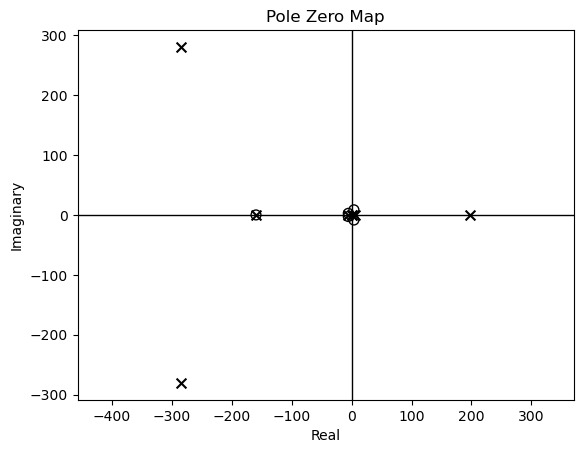

In [17]:
states = ['x_est', 'x_est_dot', 'phi_est', 'phi_est_dot']
inputs = ['x','phi']#la entrada y no puede ser de 2x1 tengo que separar
outputs = ['u_est']

#regulador con estimador total ley de control u=-k*x_est + estimador total
controlador = ctrl.ss(Ae,Be,Ce,De, states=states, inputs=inputs, outputs=outputs)
controlador

G_L = ctrl.interconnect([pendulo,controlador],inputs=['u'],outputs=['u_est'])
G_L = -G_L
ctrl.pzmap(G_L)

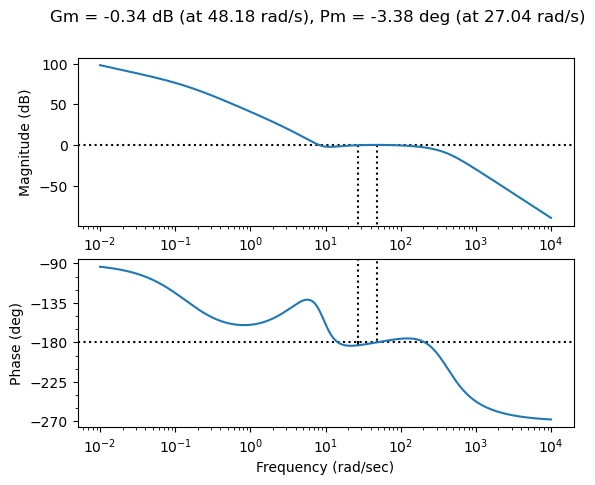

In [18]:
ctrl.bode(G_L,dB=True,margins=True);

In [19]:
ctrl.stability_margins(G_L)

(0.9616441775215193,
 -3.3767426750738423,
 0.03986876210024766,
 48.18426385873678,
 27.03571252193187,
 49.046893256102905)

-3

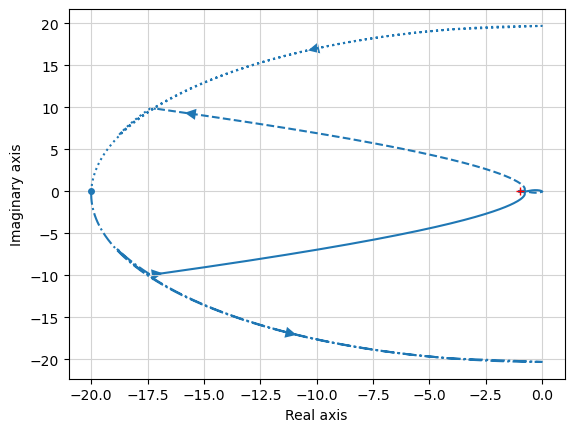

In [20]:
ctrl.nyquist(G_L)

### Implementación usando Interconnect

In [21]:
pendulo_reg = ctrl.interconnect([pendulo,reg_est_tot],inputs=['u'],outputs=['x'])
pendulo_reg

<LinearICSystem:sys[19]:['u']->['x']>

(array([-201.25 +0.j        , -161.   +0.j        ,  -40.25+41.06321346j,
         -40.25-41.06321346j,  -40.25 +0.j        ,  -32.2  +0.j        ,
          -8.05 +8.21264269j,   -8.05 -8.21264269j]),
 array([-284.37051214+280.36600594j, -284.37051214-280.36600594j,
         197.20537767  +0.j        , -159.58253521  +0.j        ,
           4.94974747  +0.j        ,   -4.94974747  +0.j        ]))

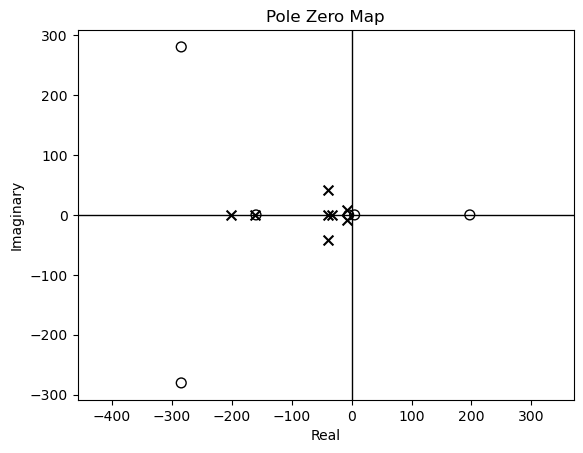

In [22]:
ctrl.pzmap(pendulo_reg)

In [23]:
n = 1000
tf = 1
time = np.linspace(0,tf,n)

u = np.ones(time.size)*.2 #escalón de 20cm
x0 = [0, 0, 0, 0 ,0,0,0,0]

t1,y1,x1 =ctrl.forced_response(pendulo_reg,U=u[0],T=time,X0=x0,return_x=True)

Text(0, 0.5, 'Posición (m)')

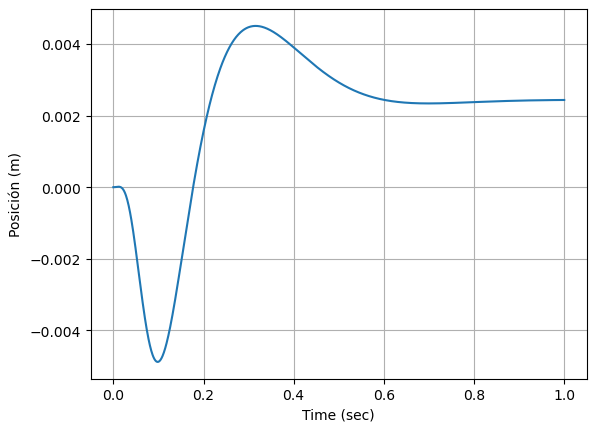

In [24]:
x=y1;
#theta_a=y1[1,:];

plt.plot(t1,x)#pos
#plt.plot(t1,theta_a)#angulo en rad

plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('Posición (m)')

In [25]:
ctrl.step_info(pendulo_reg*.2,T=time)

{'RiseTime': 0.031031031031031026,
 'SettlingTime': 0.8208208208208209,
 'SettlingMin': 0.002239159766029573,
 'SettlingMax': 0.004505505800690547,
 'Overshoot': 85.02795801234207,
 'Undershoot': 200.47797683649554,
 'Peak': 0.004881720023561441,
 'PeakTime': 0.0980980980980981,
 'SteadyStateValue': 0.0024350405468940065}

### Simulación con modelo NonlinearIOSystem
La idea fue agregar salida con ruido de medición para $x$ y $\theta$, pero me da loop algebraico y no lo pude resolver. Lo único que se puede mostrar es que la respuesta da lo mismo que antes. El problema esta al realimentar con la señal con ruido.

In [26]:
pendulo_noise = ctrl.interconnect([io_pendulum_lin,reg_est_tot],inputs=['u'],outputs=['x'])
pendulo_noise

<InterconnectedSystem:sys[24]:['u']->['x']>

In [27]:
#n = 1000
#tf = 2
time = np.linspace(0,tf,n)

u = np.ones(time.size)*.2 #escalón de 20cm
x0 = [0, 0, 0, 0 ,0,0,0,0]

t2,y2=ctrl.input_output_response(pendulo_noise, T=time, U=u[0], X0=x0,solve_ivp_method ='RK45')
y2.shape,t2.shape

((1000,), (1000,))

Text(0, 0.5, 'Posicion (m)')

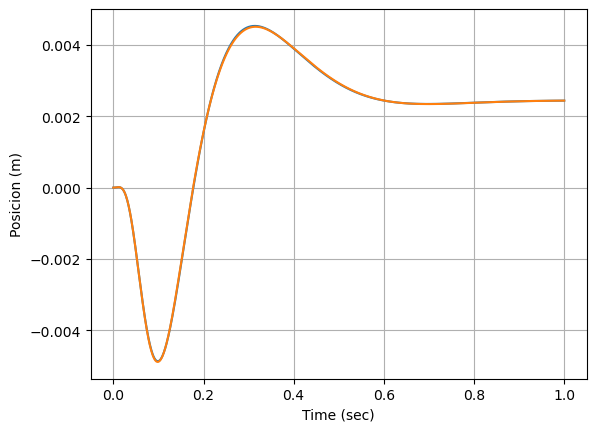

In [28]:
x=y2#[0,:];
#theta_a=y1[1,:];
plt.figure()
plt.plot(t2,x,t1,y1)#pos
#plt.plot(t1,theta_a)#angulo en rad

plt.grid()
plt.xlabel('Time (sec)')
plt.ylabel('Posicion (m)')

## Introducción de entrada de referencia

In [29]:
Nbar = 1/np.real(pendulo_reg(0))
Nbar

82.13415594048664

In [30]:
#n = 300
#tf = 1
time = np.linspace(0,tf,n)

u = np.ones(time.size)*.5 #escalón de 50cm
x0 = [0, 0, 0, 0 ,0,0,0,0]

t3,y3,x3 =ctrl.forced_response(pendulo_reg,U=u[0]*Nbar,T=time,X0=x0,return_x=True)

Text(0, 0.5, 'Posición (m)')

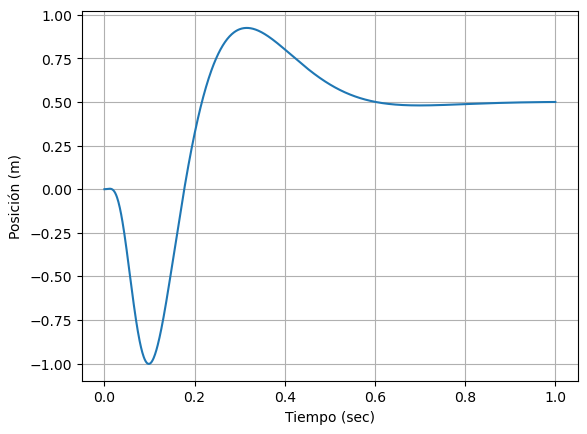

In [31]:
x=y3;
#theta_a=y1[1,:];

plt.plot(t3,x)#pos
#plt.plot(t1,theta_a)#angulo en rad

plt.grid()
plt.xlabel('Tiempo (sec)')
plt.ylabel('Posición (m)')

## Animación

In [32]:
%matplotlib qt5
#Weight of item
m2 = np.ones(n)


x1 = x
y1 = np.zeros(len(time))

#suppose that l = 1
x2 = 1*np.sin(theta_a)+x1
x2b = 1.05*np.sin(theta_a)+x1
y2 = 1*np.cos(theta_a)-y1
y2b = 1.05*np.cos(theta_a)-y1

# Pendulum animation by Everton Colling

fig = plt.figure(figsize=(8,6.4))
ax = fig.add_subplot(111,autoscale_on=False,\
                     xlim=(-1.8,1.8),ylim=(-0.4,1.2))
ax.set_xlabel('position')
ax.get_yaxis().set_visible(False)

crane_rail, = ax.plot([-2.0,2.0],[-0.2,-0.2],'k-',lw=4)
start, = ax.plot([-1,-1],[-1.5,1.5],'k:',lw=2)
pos2, = ax.plot([1,1],[-1.5,1.5],'k:',lw=2)
pos_p5, = ax.plot([.5,.5],[-1.5,1.5],'k:',lw=2)

objective, = ax.plot([0,0],[-0.5,1.5],'k:',lw=2)
mass1, = ax.plot([],[],linestyle='None',marker='s',\
                 markersize=40,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
mass2, = ax.plot([],[],linestyle='None',marker='o',\
                 markersize=20,markeredgecolor='k',\
                 color='orange',markeredgewidth=2)
line, = ax.plot([],[],'o-',color='orange',lw=4,\
                markersize=6,markeredgecolor='k',\
                markerfacecolor='k')
time_template = 'time = %.1fs'
time_text = ax.text(0.05,0.9,'',transform=ax.transAxes)
wgt_template = 'weight = %.1f'
wgt_text = ax.text(0.75,0.9,'',transform=ax.transAxes)
#start_text = ax.text(-1.06,-0.3,'pos1',ha='right')
#end_text = ax.text(0.06,-0.3,'objective',ha='left')

def init():
    mass1.set_data([],[])
    mass2.set_data([],[])
    line.set_data([],[])
    time_text.set_text('')
    wgt_text.set_text('')
    return line, mass1, mass2, time_text, wgt_text

def animate(i):
    mass1.set_data([x1[i]],[y1[i]-0.1])
    mass2.set_data([x2b[i]],[y2b[i]])
    line.set_data([x1[i],x2[i]],[y1[i],y2[i]])
    time_text.set_text(time_template % time[i])
    wgt_text.set_text(wgt_template % m2[i])
    return line, mass1, mass2, time_text, wgt_text

ani_a = animation.FuncAnimation(fig, animate, \
         np.arange(1,len(time)), \
         interval=40,blit=False,init_func=init)

# requires ffmpeg to save mp4 file
#  available from https://ffmpeg.zeranoe.com/builds/
#  add ffmpeg.exe to path such as C:\ffmpeg\bin\ in
#  environment variables
#ani_a.save('Pendulum_Control.mp4',fps=30)
#ani_a.save('animation.gif', writer='PillowWriter', fps=30)
plt.show()

ValueError: operands could not be broadcast together with shapes (300,) (1000,) 